# 1 FASTA File

obtain FASTA files of protein sequences of the following 7 species from NCBI Genome Database.
- Arabidopsis thaliana
- Human
- Mouse
- Zebrafish
- Chlamydomonas (green alga)
- Cyanidioschizone (red alga)
- Budding yeast

# 2 Proteins Lenght Comparison
Proteins are composed of a series of amino acids, but their length and composition vary from protein to protein. Proteins vary in length, but by looking at the distribution of the length of proteins encoded by a given genome, we can understand the overall picture (proteome) of the proteins of that species. Compare the distribution of protein lengths of each species using the following visualization method. Consider whether converting the protein lengths to logarithmic values changes the interpretation.
- Density distribution
- Box-and-whisker plot
- Violin plot

In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scikit_posthocs as sp
from scipy.stats import kruskal


def parse_fasta_folder(input_folder):
    """
    input_folder - folder containing .faa files
    return - DataFrame with 'Species', 'Protein ID', 'Protein Length'
    """
    parsed_seqs = {}

    # Iterate through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.faa'):
            species_name = filename[:-4]  # Assuming species name is the filename without extension
            file_path = os.path.join(input_folder, filename)
            
            with open(file_path) as f:
                curr_seq_id = None
                curr_seq = []

                for line in f:
                    line = line.strip()

                    if line.startswith(">"):
                        if curr_seq_id is not None:
                            parsed_seqs[curr_seq_id] = (species_name, ''.join(curr_seq))

                        curr_seq_id = line[1:]
                        curr_seq = []
                        continue

                    curr_seq.append(line)

                # Add the final sequence to the dict
                if curr_seq_id is not None:
                    parsed_seqs[curr_seq_id] = (species_name, ''.join(curr_seq))

    print(f"Total sequences parsed: {len(parsed_seqs)}")
    return parsed_seqs

def convert_to_dataframe(parsed_seqs):
    """
    Convert the parsed sequences dictionary to a DataFrame.
    """
    data = []
    for seq_id, (species, seq) in parsed_seqs.items():
        data.append({'Protein ID': seq_id, 'Species': species, 'Sequence':seq, 'Protein Length': len(seq)})
    
    return pd.DataFrame(data)


In [2]:
def filter_proteins(df):
    """
    Filters proteins based on the Carugo (2008) paper criteria:
    - Protein length between 50 and 200 residues.
    - Contains only standard amino acids (A, R, N, D, C, E, Q, G, H, I, L, K, M, F, P, S, T, W, Y, V).
    
    df - DataFrame containing parsed protein sequences.
    return - Filtered DataFrame.
    """
    # Define the standard amino acids
    standard_amino_acids = set("ARNDCEQGHILKMFPSTWYV")
    
    # Function to check if sequence contains only standard amino acids
    def contains_only_standard_amino_acids(seq):
        return all(aa in standard_amino_acids for aa in seq)

    # Apply filters: length between 50 and 200 and only standard amino acids
    filtered_df = df[
        (df['Protein Length'] >= 50) & 
        (df['Protein Length'] <= 200) & 
        (df['Sequence'].apply(contains_only_standard_amino_acids))
    ]
    
    print(f"Total proteins after filtering: {len(filtered_df)}")
    return filtered_df

In [3]:
# After you have the dataframe from the parsed fasta folder
parsed_seqs = parse_fasta_folder('assignment01_data')
df = convert_to_dataframe(parsed_seqs)
df.head()

Total sequences parsed: 365746


,Protein ID,Species,Sequence,Protein Length
0,NP_001018029.1 Coq21p [Saccharomyces cerevisia...,Saccharomyces cerevisiae protein,MRNELYQLWCVASAARGVAKSSFVRANSAMCEYVRTSNVLSRWTRD...,66
1,NP_001018030.1 L-serine/L-threonine ammonia-ly...,Saccharomyces cerevisiae protein,MSIVYNKTPLLRQFFPGKASAQFFLKYECLQPSGSFKSRGIGNLIM...,360
2,NP_001018031.2 Adf1p [Saccharomyces cerevisiae...,Saccharomyces cerevisiae protein,MGKCSMKKKGVGKNVGVGKKVQKKRSISTAERKRTKLQVEKLNKSS...,113
3,NP_001018032.1 uncharacterized protein YCR095W...,Saccharomyces cerevisiae protein,MTVLIKLGLRILHVYKGFFRKVILKYFFFSSEHTKVNKKSSMHAFL...,52
4,NP_001018033.3 uncharacterized protein YGR161W...,Saccharomyces cerevisiae protein,MSGYFNHLSSNAHFANIQADQGFIGDATGTSSDHGSSGMVDFALQL...,92


In [12]:
# Apply the filter to the parsed DataFrame
df = filter_proteins(df)
df.head()

Total proteins after filtering: 46518


,Protein ID,Species,Sequence,Protein Length,Log Protein Length
0,NP_001018029.1 Coq21p [Saccharomyces cerevisia...,Saccharomyces cerevisiae protein,MRNELYQLWCVASAARGVAKSSFVRANSAMCEYVRTSNVLSRWTRD...,66,1.819544
2,NP_001018031.2 Adf1p [Saccharomyces cerevisiae...,Saccharomyces cerevisiae protein,MGKCSMKKKGVGKNVGVGKKVQKKRSISTAERKRTKLQVEKLNKSS...,113,2.053078
3,NP_001018032.1 uncharacterized protein YCR095W...,Saccharomyces cerevisiae protein,MTVLIKLGLRILHVYKGFFRKVILKYFFFSSEHTKVNKKSSMHAFL...,52,1.716003
4,NP_001018033.3 uncharacterized protein YGR161W...,Saccharomyces cerevisiae protein,MSGYFNHLSSNAHFANIQADQGFIGDATGTSSDHGSSGMVDFALQL...,92,1.963788
5,NP_001027023.1 Nag1p [Saccharomyces cerevisiae...,Saccharomyces cerevisiae protein,MNSAGRVHRSRAGSRGHAAISPLTMASFSVARGIRSSNVYDDTDDE...,163,2.212188


In [17]:
# Set Seaborn style and palette
sns.set(style='whitegrid', palette='Set2')

def plot_protein_length_distribution(df):
    # Add a column for log-transformed protein lengths
    df['Log Protein Length'] = np.log10(df['Protein Length'])
    
    # Set up the plotting area
    plt.figure(figsize=(15, 10))

    # Density Distribution for Protein Length
    plt.subplot(2, 2, 1)
    unique_species = df['Species'].unique()
    for species in unique_species:
        subset = df[df['Species'] == species]
        sns.kdeplot(data=subset, x='Protein Length', fill=False, label=species, common_norm=True, bw_adjust=0.5)

    plt.title('Density Distribution of Protein Lengths')
    plt.legend(title='Species', loc='lower right')

    plt.subplot(2, 2, 2)
    for species in unique_species:
        subset = df[df['Species'] == species]
        sns.kdeplot(data=subset, x='Log Protein Length', fill=False, label=species, common_norm=True, bw_adjust=0.5)

    plt.title('Density Distribution of Log Protein Lengths')
    plt.legend(title='Species', loc='upper left')

    # Box-and-Whisker Plot
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df, x='Species', y='Protein Length', hue='Species')
    plt.title('Box-and-Whisker Plot of Protein Lengths')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 4)
    sns.boxplot(data=df, x='Species', y='Log Protein Length', hue='Species')
    plt.title('Box-and-Whisker Plot of Log Protein Lengths')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Violin Plot
    plt.figure(figsize=(15, 6))

    # Violin Plot for Protein Length
    plt.subplot(1, 2, 1)
    sns.violinplot(data=df, x='Species', y='Protein Length', hue='Species')
    plt.title('Violin Plot of Protein Lengths')
    plt.xticks(rotation=45)

    # Violin Plot for Log Protein Length
    plt.subplot(1, 2, 2)
    sns.violinplot(data=df, x='Species', y='Log Protein Length', hue='Species')
    plt.title('Violin Plot of Log Protein Lengths')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()



/var/folders/yw/bg8nnxbs2tv4pz7s83z6djjw0000gn/T/ipykernel_23287/1975342533.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  density /= np.trapz(density, x)  # Integrate and normalize
/var/folders/yw/bg8nnxbs2tv4pz7s83z6djjw0000gn/T/ipykernel_23287/1975342533.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"Total area under curve for {species}: {np.trapz(density, x)}")
/var/folders/yw/bg8nnxbs2tv4pz7s83z6djjw0000gn/T/ipykernel_23287/1975342533.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"Total area under curve for {species}: {np.trapz(density, x)}")


Total area under curve for Saccharomyces cerevisiae protein: 1.0
Total area under curve for Mouse protein: 0.9999999999999999
Total area under curve for Chlamydomonas protein: 0.9999999999999998
Total area under curve for Arabidopsis thaliana protein: 0.9999999999999998
Total area under curve for Zebrafish protein: 1.0
Total area under curve for Cyanidioschyzon protein: 1.0
Total area under curve for Human protein: 1.0000000000000002
Total area under curve for Saccharomyces cerevisiae protein: 0.9999999999999999
Total area under curve for Mouse protein: 1.0000000000000002
Total area under curve for Chlamydomonas protein: 1.0
Total area under curve for Arabidopsis thaliana protein: 1.0
Total area under curve for Zebrafish protein: 1.0000000000000002
Total area under curve for Cyanidioschyzon protein: 1.0
Total area under curve for Human protein: 1.0


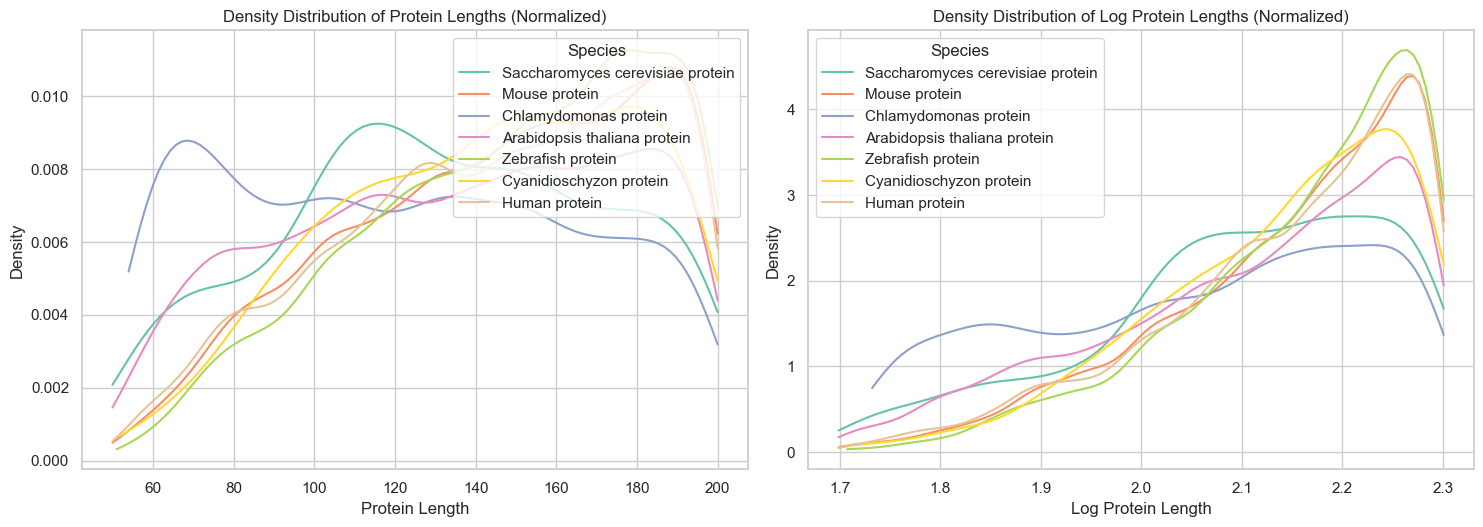

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def calculate_density(data):
    data = np.array(data)
    data = data[~np.isnan(data)]
    kde = gaussian_kde(data)
    
    # Create a range of values
    x = np.linspace(np.min(data), np.max(data), 100)
    density = kde(x)
    
    # Normalize the density so that the area under the curve is 1
    density /= np.trapz(density, x)  # Integrate and normalize
    
    return x, density

df['Log Protein Length'] = np.log10(df['Protein Length'])

# Set up the plotting area
plt.figure(figsize=(15, 10))

# Density Distribution for Protein Length
plt.subplot(2, 2, 1)
unique_species = df['Species'].unique()
for species in unique_species:

    subset = df[df['Species'] == species]
    x, density = calculate_density(subset['Protein Length'])
    print(f"Total area under curve for {species}: {np.trapz(density, x)}")
    plt.plot(x, density, label=species)

plt.title('Density Distribution of Protein Lengths (Normalized)')
plt.xlabel('Protein Length')
plt.ylabel('Density')
plt.legend(title='Species', loc='upper right')

# Density Distribution for Log Protein Length
plt.subplot(2, 2, 2)
for species in unique_species:
    subset = df[df['Species'] == species]
    x, density = calculate_density(subset['Log Protein Length'])
    print(f"Total area under curve for {species}: {np.trapz(density, x)}")
    plt.plot(x, density, label=species)

plt.title('Density Distribution of Log Protein Lengths (Normalized)')
plt.xlabel('Log Protein Length')
plt.ylabel('Density')
plt.legend(title='Species', loc='upper left')

plt.tight_layout()
plt.show()



Total sequences parsed: 365746
Total proteins after filtering: 46518


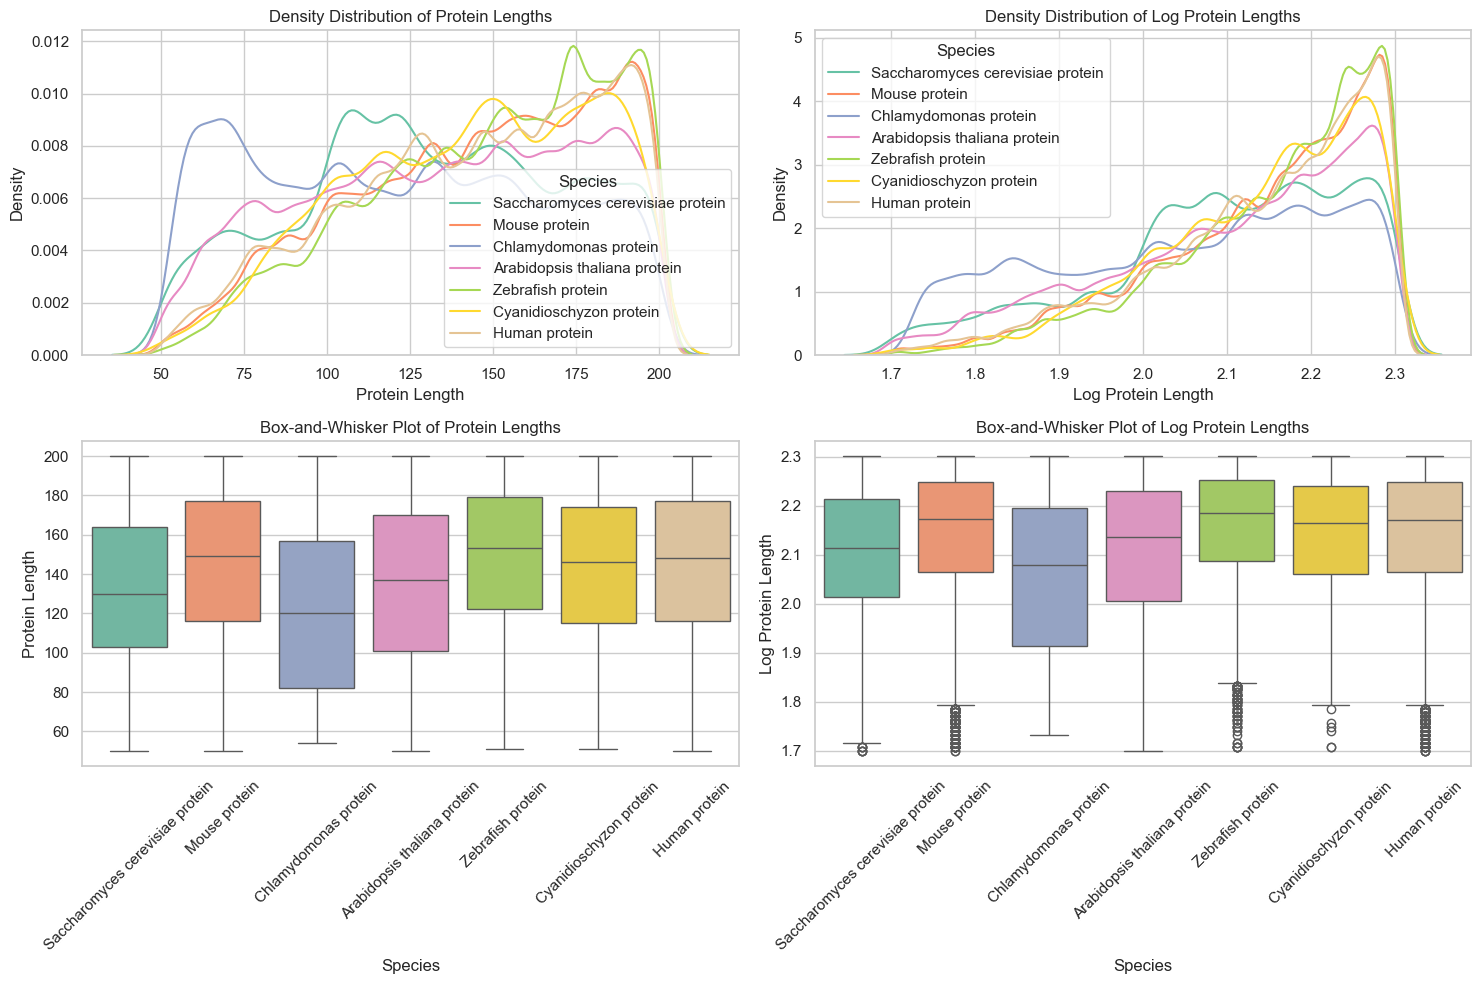

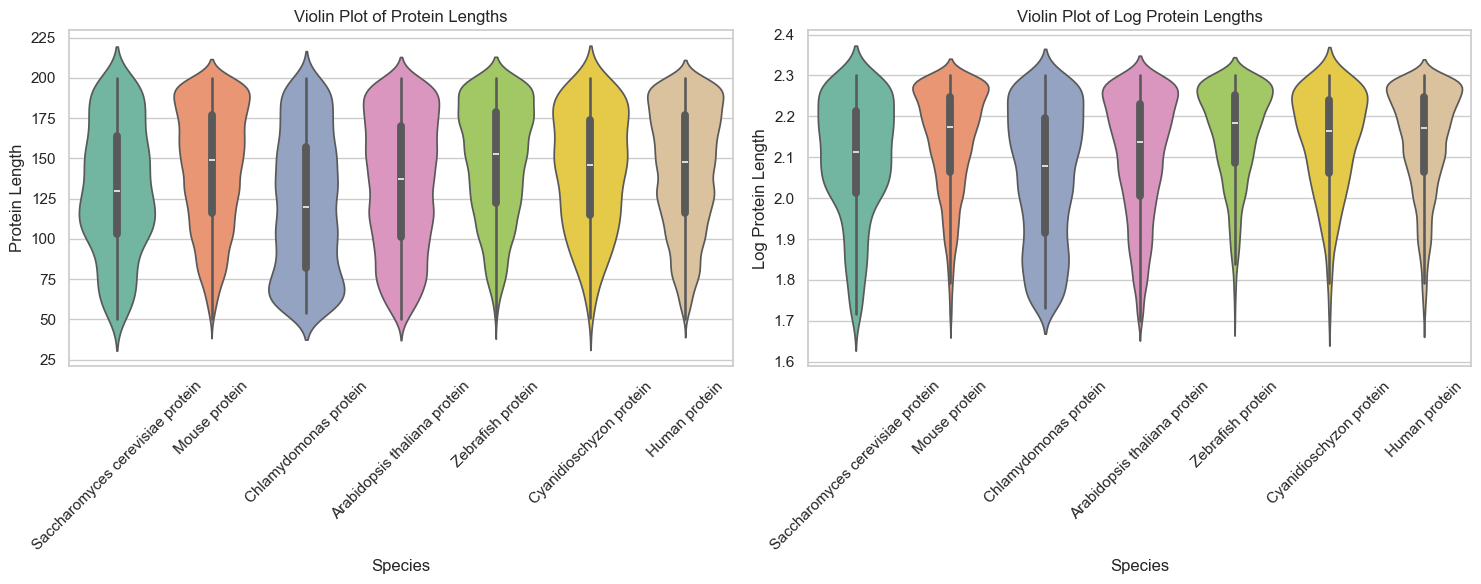

In [18]:
# After you have the dataframe from the parsed fasta folder
parsed_seqs = parse_fasta_folder('assignment01_data')
df = convert_to_dataframe(parsed_seqs)
df = filter_proteins(df)

# Call the function to generate the plots
plot_protein_length_distribution(df)

Area under the KDE curve for species Saccharomyces cerevisiae protein: 0.999958929396833
Area under the KDE curve for species Mouse protein: 0.999958929396833
Area under the KDE curve for species Chlamydomonas protein: 0.999958929396833
Area under the KDE curve for species Arabidopsis thaliana protein: 0.999958929396833
Area under the KDE curve for species Zebrafish protein: 0.999958929396833
Area under the KDE curve for species Cyanidioschyzon protein: 0.999958929396833
Area under the KDE curve for species Human protein: 0.999958929396833


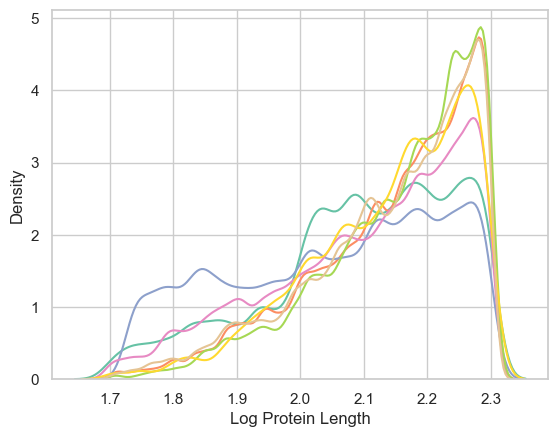

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'Protein Length' and 'Species' columns exist
df['Log Protein Length'] = np.log10(df['Protein Length'])

# Set up KDE for integration
unique_species = df['Species'].unique()

for species in unique_species:
    subset = df[df['Species'] == species]
    
    # Calculate the KDE for Protein Length
    kde = sns.kdeplot(data=subset, x='Log Protein Length', fill=False, bw_adjust=0.5)
    
    # Get the x and y values of the KDE plot
    x = kde.lines[0].get_xdata()
    y = kde.lines[0].get_ydata()

    # Numerically integrate the area under the curve
    auc = np.trapezoid(y, x)
    
    print(f"Area under the KDE curve for species {species}: {auc}")


In [ ]:
def run_kruskal_wallis_test(df):
    """
    Perform Kruskal-Wallis test to compare protein length distributions
    between species.
    
    df - DataFrame containing 'Species' and 'Protein Length' columns
    """
    # Get the unique species in the dataset
    unique_species = df['Species'].unique()

    # Group protein lengths by species
    species_groups = [df[df['Species'] == species]['Protein Length'].values for species in unique_species]

    # Perform Kruskal-Wallis test
    kruskal_stat, p_value = kruskal(*species_groups)

    print(f"Kruskal-Wallis test statistic: {kruskal_stat}")
    print(f"P-value: {p_value}")
    
    # Interpret the result
    alpha = 0.05  # Significance level
    if p_value < alpha:
        print("There is a significant difference in protein length distributions between species.")
        run_dunns_test(df)
    else:
        print("There is no significant difference in protein length distributions between species.")

def run_dunns_test(df):
    """
    Perform Dunn's test for pairwise comparisons if Kruskal-Wallis test is significant,
    and visualize the results using a heatmap.
    
    df - DataFrame containing 'Species' and 'Protein Length' columns
    """
    # Dunn's test with Bonferroni correction for multiple comparisons
    dunn_result = sp.posthoc_dunn(df, val_col='Protein Length', group_col='Species', p_adjust='bonferroni')

    print("\nDunn's Test Results (pairwise p-values):")
    print(dunn_result)

    # Visualizing the results with a heatmap
    visualize_dunn_test_results(dunn_result)

def visualize_dunn_test_results(dunn_result):
    """
    Visualize the pairwise p-values from Dunn's test as a heatmap.
    
    dunn_result - DataFrame of Dunn's test p-values
    """
    plt.figure(figsize=(10, 8))

    # Create a heatmap with p-values, using a logarithmic scale for better visualization
    sns.heatmap(dunn_result, annot=True, cmap="coolwarm", cbar_kws={'label': 'P-Value'}, 
                linewidths=0.5, fmt=".3f")

    plt.title("Dunn's Test Pairwise P-Value Heatmap")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

# Call the function after parsing the sequences and creating the DataFrame
parsed_seqs = parse_fasta_folder('assignment01_data')
df = convert_to_dataframe(parsed_seqs)

# Run the Kruskal-Wallis test
run_kruskal_wallis_test(filtered_df)


# 3 Relation between Amino content and Lenght
Proteins are composed of a series of 20 different amino acids, but the amino acid content of each amino acid is different for each protein. Find out if the amino acid content of each protein is related to the length of the protein.
- Scatter Plot
- Summarize trends (linear regression, lowess)
- Visualization of amino acid composition profiles (heat maps)
- Visualization of amino acid composition profiles (hierarchical clustering)
- Visualization of amino acid composition profiles (Principal Component Analysis)

# 4 Amino acid composition comparison
Compare the seven species in terms of amino acid composition of proteins.
- Amino acid composition at representative gene lengths
- Comparison of amino acid composition of species (heat map)
- Comparison of amino acid composition of species (hierarchical clustering)
- Comparison of amino acid compositions of species (Principal Component Analysis)

# 5 Specie prediction based on Protien Commposition